# Multi-Classification Modeling with top 4 beacons with DNN no preprocessing
## Index
- Load data & import modules
- Preprocessing & split
- DNN modeling
- Ploting 
- Confusion Matrix


# Load data & import moduels
- tensorflow version 2.9.1 required

In [ ]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%cd drive/MyDrive/BEST/ios_clf_direction

/content/drive/MyDrive/BEST/ios_clf_direction


In [ ]:
datas = [] 
data_name = [('S', [1,2,3,4,5,6,7,8,9]), ('E', [1,2,3]), ('R',[1,2,3,4,5]), ('H', [1,2]), ('A', [1,2,3,4,5,6,7,8,9,10,11]), ('U', [1]) ]

#ios_clf_data_4_concatedS04

for data in data_name:
  for index in data[1]: 
    if index < 10:
      no_supervised = pd.DataFrame(pd.read_csv(f'Filtered_{data[0]}0{index}.csv'))
      no_supervised.drop(['timeStamp'], axis=1, inplace = True)
      no_supervised.insert(0, 'location' ,f'{data[0]}0{index}')
    else:
      no_supervised = pd.DataFrame(pd.read_csv(f'Filtered_{data[0]}{index}.csv'))
      no_supervised.drop(['timeStamp'], axis=1, inplace = True)
      no_supervised.insert(0, 'location' ,f'{data[0]}{index}')
    datas.append(no_supervised)

def tominus200(x) :
  if float(x) <= -90 :
    return -200
  return float(x)

beacons = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021', '022']
for data in datas:
  for beacon in beacons:
    data[beacon] = data[beacon].apply(tominus200)

In [ ]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pathlib

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.8.2


# Preprocessing & split
- Concat all the data
- split into 7:3

In [ ]:
result = pd.concat(datas)

In [ ]:
result.loc[result['location'] == 'A011', 'location'] = 'A11'
result.loc[result['location'] == 'A010', 'location'] = 'A10'

In [ ]:
result.drop('heading', axis=1, inplace=True)
result.drop('direction', axis=1, inplace=True)

In [ ]:
data_all = []

for data in data_name:
  for index in data[1]: 
    if index < 10:
      prev = pd.DataFrame(pd.read_csv(f'../clf_data_iOS/{data[0]}0{index}.csv'))
      prev.drop(['timeStamp', 'accer_x', 'accer_y','accer_z','gyro_x','gyro_y','gyro_z','magn_x','magn_y','magn_z'], axis=1, inplace=True)
      prev.insert(0, 'location' ,f'{data[0]}0{index}')

    else:
      prev = pd.DataFrame(pd.read_csv(f'../clf_data_iOS/{data[0]}{index}.csv'))
      prev.drop(['timeStamp', 'accer_x', 'accer_y','accer_z','gyro_x','gyro_y','gyro_z','magn_x','magn_y','magn_z'], axis=1, inplace=True)
      prev.insert(0, 'location' ,f'{data[0]}{index}')
    data_all.append(prev)

def tominus200(x) :
  if float(x) <= -90 :
    return -200
  return float(x)

beacons = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021', '022']
for data in data_all:
  for beacon in beacons:
    data[beacon] = data[beacon].apply(tominus200)

In [ ]:
data_all[0]

,location,001,002,003,004,005,006,007,008,009,...,013,014,015,016,017,018,019,020,021,022
0,S01,-77.000000,-70.000000,-87.00000,-74.00000,-87.000000,-200.000000,-200.000000,-200.000000,-83.000000,...,-200.000000,-61.000000,-200,-200,-200,-200,-200,-63.000000,-200,-200
1,S01,-77.000000,-68.999000,-83.99700,-76.00200,-200.000000,-200.000000,-200.000000,-200.000000,-83.500496,...,-200.000000,-62.001000,-200,-200,-200,-200,-200,-64.001000,-200,-200
2,S01,-76.665560,-200.000000,-82.66023,-76.67021,-200.000000,-88.498505,-200.000000,-82.000000,-84.001990,...,-73.000000,-62.335106,-200,-200,-200,-200,-200,-200.000000,-200,-200
3,S01,-200.000000,-72.343760,-81.99053,-200.00000,-85.498505,-87.328450,-86.997000,-82.500496,-200.000000,...,-73.500496,-62.502487,-200,-200,-200,-200,-200,-60.990680,-200,-200
4,S01,-77.253240,-73.767690,-200.00000,-77.25672,-85.666230,-86.490530,-85.994675,-81.998670,-84.504980,...,-73.667550,-200.000000,-200,-200,-200,-200,-200,-59.734303,-200,-200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,S01,-85.619850,-200.000000,-87.47549,-82.10920,-200.000000,-200.000000,-200.000000,-89.567800,-88.407950,...,-76.530260,-68.148990,-200,-200,-200,-200,-200,-200.000000,-200,-200
483,S01,-200.000000,-75.836460,-200.00000,-200.00000,-200.000000,-200.000000,-200.000000,-89.674170,-200.000000,...,-76.725746,-68.273674,-200,-200,-200,-200,-200,-51.603380,-200,-200
484,S01,-85.767685,-76.106026,-200.00000,-82.14816,-200.000000,-200.000000,-200.000000,-89.863360,-200.000000,...,-77.131355,-200.000000,-200,-200,-200,-200,-200,-51.708195,-200,-200
485,S01,-85.909050,-76.101390,-87.67336,-82.18542,-200.000000,-200.000000,-200.000000,-200.000000,-88.652520,...,-77.650440,-68.305440,-200,-200,-200,-200,-200,-51.852160,-200,-200


In [ ]:
result = []
for index in range(len(datas)):
  new = pd.concat([datas[index], data_all[index]])
  result.append(new)

In [ ]:
result = pd.concat(result)

In [ ]:
result.drop('heading', axis=1, inplace=True)
result.drop('direction', axis=1, inplace=True)

In [ ]:
result.loc[result['location'] == 'A011', 'location'] = 'A11'
result.loc[result['location'] == 'A010', 'location'] = 'A10'

# DNN modeling
- Multi-Classification with Top 5 beacons


# Hyperparameter Tuning
- Normalization : Weight Normalization
- learning rate : [0.01, 0.001, 0.0001]
- loss: categorical_crossentropy
- Optimaization: Adam
- epoch: 50
- output layer: 31
- activation: Relu
- activation: Softmax

# Result
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.001.

- loss: 0.2959
- accuracy: 0.8853 
- precision: 0.8909 
- recall: 0.8813 
- f1_score: 0.8779 
- 450ms/epoch - 3ms/step


In [ ]:
np.set_printoptions(precision=2)
le = LabelEncoder()

X = np.array(result.iloc[:, 1:])
y = le.fit_transform(np.array(result['location']).reshape(-1, 1))
y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
len(X[0])

22

In [ ]:
X = np.asarray(X).astype(np.float32)

In [ ]:
len(X[0])

22

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42,shuffle=True)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_addons as tfa

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
!pip install IPython
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tf.random.set_seed(42)
initializer = tf.keras.initializers.HeNormal()

def model_builder(hp):
   model = keras.Sequential()
    
   # Dense layer unit number 32~256
   hp_unit = hp.Int('units', min_value=32, max_value=256, step=32)
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22], kernel_initializer=initializer)))
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22],kernel_initializer=initializer)))
   model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(units=hp_unit, activation = tf.keras.activations.relu, input_shape=[22],kernel_initializer=initializer)))
  #  model.add(keras.layers.Dropout(0.5))
   model.add(keras.layers.Dense(31, activation = 'softmax'))

   # (learning rate) = [0.01, 0.001, 0.0001]
   hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

   opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)
   loss = tf.keras.losses.categorical_crossentropy
   model.compile(optimizer= opt, loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=31, average='macro', threshold=0.5)])


   return model

In [ ]:
len(X_train[0])

22

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 30,
                     factor=3,
                     hyperband_iterations=2,
                     directory = 'hi2',
                     project_name = 'ios_clf_10')

INFO:tensorflow:Reloading Oracle from existing project hi2/ios_clf_10/oracle.json


INFO:tensorflow:Reloading Oracle from existing project hi2/ios_clf_10/oracle.json


INFO:tensorflow:Reloading Tuner from hi2/ios_clf_10/tuner0.json


INFO:tensorflow:Reloading Tuner from hi2/ios_clf_10/tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
model_based_tuner = tuner.hypermodel.build(best_hps)
history = model_based_tuner.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_train,y_train), callbacks= [ClearTrainingOutput()])

Epoch 1/50
674/674 [==============================] - 13s 15ms/step - loss: 2.0347 - accuracy: 0.3576 - precision_5: 0.7508 - recall_5: 0.0652 - f1_score: 0.1079 - val_loss: 1.4024 - val_accuracy: 0.5245 - val_precision_5: 0.7896 - val_recall_5: 0.1801 - val_f1_score: 0.2533
Epoch 2/50
674/674 [==============================] - 8s 12ms/step - loss: 1.2291 - accuracy: 0.5774 - precision_5: 0.7875 - recall_5: 0.2903 - f1_score: 0.3940 - val_loss: 1.0636 - val_accuracy: 0.6285 - val_precision_5: 0.8111 - val_recall_5: 0.3928 - val_f1_score: 0.4914
Epoch 3/50
674/674 [==============================] - 8s 11ms/step - loss: 1.0069 - accuracy: 0.6493 - precision_5: 0.8017 - recall_5: 0.4423 - f1_score: 0.5485 - val_loss: 0.9167 - val_accuracy: 0.6706 - val_precision_5: 0.8118 - val_recall_5: 0.4987 - val_f1_score: 0.5865
Epoch 4/50
674/674 [==============================] - 8s 12ms/step - loss: 0.8885 - accuracy: 0.6805 - precision_5: 0.8016 - recall_5: 0.5195 - f1_score: 0.6153 - val_loss: 0

In [ ]:
model_based_tuner_dict = history.history
model_based_tuner_dict.keys()

dict_keys(['loss', 'accuracy', 'precision_5', 'recall_5', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_5', 'val_f1_score'])

In [ ]:
results = model_based_tuner.evaluate(X_test,  y_test, verbose=2)

289/289 - 1s - loss: 0.4974 - accuracy: 0.8493 - precision_5: 0.8654 - recall_5: 0.8374 - f1_score: 0.8478 - 579ms/epoch - 2ms/step


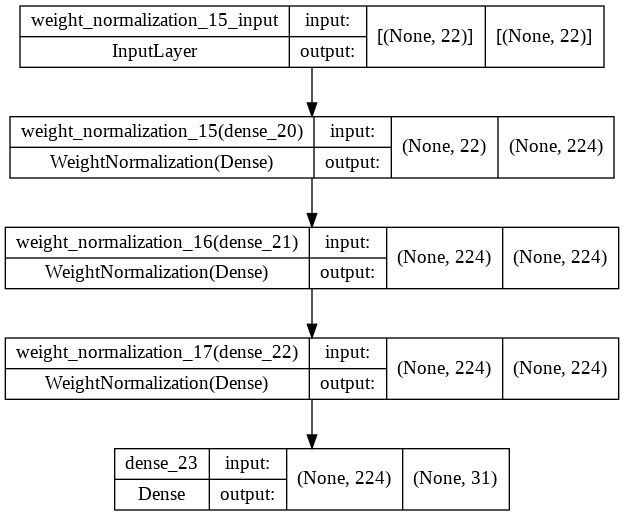

In [ ]:
keras.utils.plot_model(model_based_tuner, "beacon4_no_preprocessing.png", show_shapes=True)

# Ploting

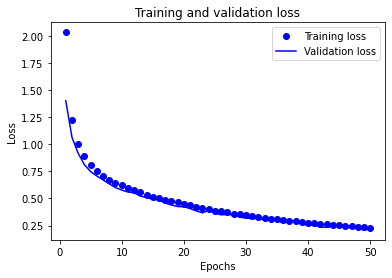

In [ ]:
acc = model_based_tuner_dict['accuracy']
val_acc = model_based_tuner_dict['val_accuracy']
loss = model_based_tuner_dict['loss']
val_loss = model_based_tuner_dict['val_loss']
recall = model_based_tuner_dict['recall_5']
val_recall = model_based_tuner_dict['val_recall_5']
f1_score = model_based_tuner_dict['f1_score']
val_f1_score = model_based_tuner_dict['val_f1_score']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

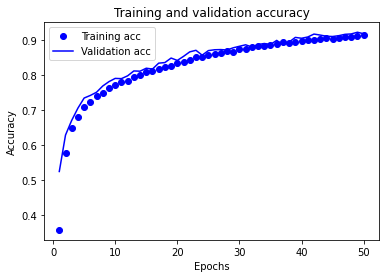

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

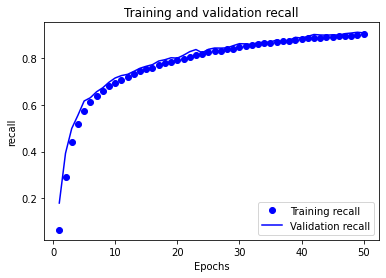

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()

plt.show()

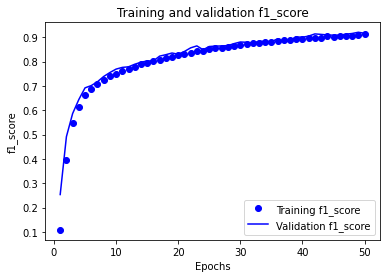

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, f1_score, 'bo', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [ ]:
X_test[0]

array([-200.  ,  -85.92,  -67.28, -200.  ,  -77.88,  -76.18,  -80.3 ,
        -76.78, -200.  ,  -79.79, -200.  ,  -86.4 ,  -85.47,  -79.18,
       -200.  ,  -84.32, -200.  ,  -88.96, -200.  ,  -85.07, -200.  ,
       -200.  ], dtype=float32)

#Confusion Matrix

9242
[16 17 10 ...  4 16 24]
Confusion Matrix


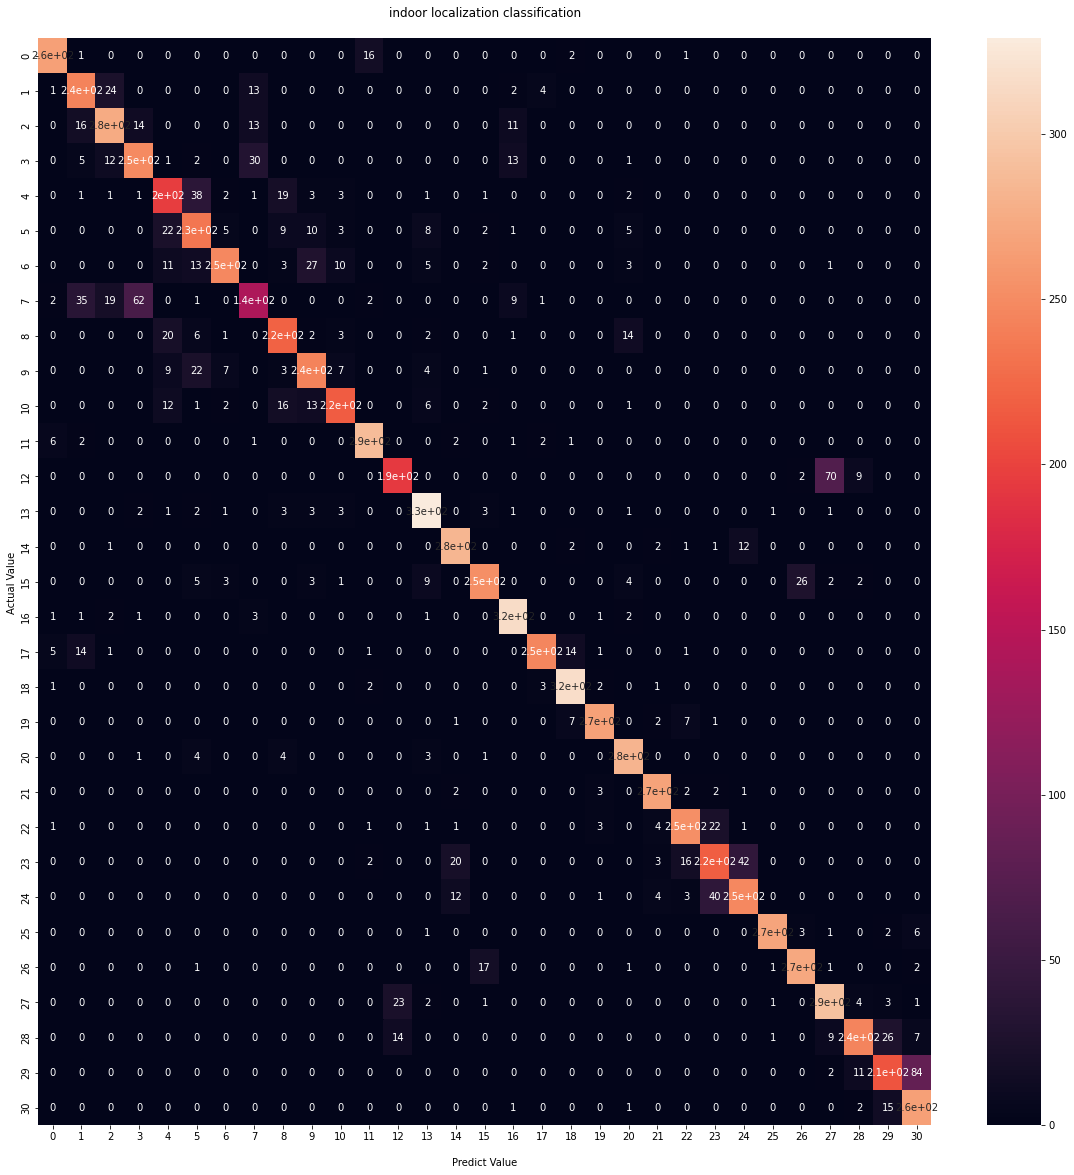

In [ ]:
from sklearn.metrics import confusion_matrix
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model_based_tuner.predict(X_test),axis=1)
print(len(X_test))
print(Y_pred)
print('Confusion Matrix')

cf_matrix = confusion_matrix(y_test_arg, Y_pred)

plt.figure(figsize=(20, 20)) 
ax = sns.heatmap(cf_matrix, annot = True)
ax.set_title('indoor localization classification\n')
ax.set_xlabel('\nPredict Value')
ax.set_ylabel('Actual Value ')
plt.show()

# TEST Data

In [ ]:
testdatas = [] 
data_name = [('S', [1,2,3,4,5,6,7,8,9]), ('E', [1,2,3]), ('R',[1,2,3,4,5]), ('H', [1,2]), ('A', [1,2,3,4,5,6,7,8,9,10,11]), ('U', [1]) ]

#Filtered_Test_U01

for data in data_name:
  for index in data[1]: 
    if index < 10:
      no_supervised = pd.DataFrame(pd.read_csv(f'../test_data/Filtered_Test_{data[0]}0{index}.csv'))
      no_supervised.drop('direction', axis=1, inplace=True)
      no_supervised.drop('timeStamp', axis=1, inplace=True)
      no_supervised.drop('heading', axis=1, inplace=True)
      no_supervised.insert(0, 'location' ,f'{data[0]}0{index}')
    else:
      no_supervised = pd.DataFrame(pd.read_csv(f'../test_data/Filtered_Test_{data[0]}{index}.csv'))
      no_supervised.drop('direction', axis=1, inplace=True)
      no_supervised.drop('heading', axis=1, inplace=True)
      no_supervised.drop('timeStamp', axis=1, inplace=True)
      no_supervised.insert(0, 'location' ,f'{data[0]}{index}')
    testdatas.append(no_supervised)


def tominus200(x) :
  if float(x) <= -90 :
    return -200
  return float(x)

beacons = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021', '022']
for data in testdatas:
  for beacon in beacons:
    data[beacon] = data[beacon].apply(tominus200)

In [ ]:
testdatas[0]

,location,001,002,003,004,005,006,007,008,009,...,013,014,015,016,017,018,019,020,021,022
0,S01,-200.000000,-70.00000,-200.0,-88.00000,-200.000000,-200,-200.0,-200.000000,-200,...,-84.000000,-62.000000,-200,-200,-200,-200,-200,-53.000000,-200,-200
1,S01,-89.498505,-70.00000,-200.0,-86.99900,-200.000000,-200,-200.0,-200.000000,-200,...,-83.499504,-63.501500,-200,-200,-200,-200,-200,-53.000000,-200,-200
2,S01,-89.666230,-200.00000,-200.0,-200.00000,-200.000000,-200,-200.0,-89.996670,-200,...,-82.663570,-200.000000,-200,-200,-200,-200,-200,-53.000000,-200,-200
3,S01,-200.000000,-68.99667,-200.0,-85.66156,-200.000000,-200,-200.0,-200.000000,-200,...,-82.244770,-63.668220,-200,-200,-200,-200,-200,-200.000000,-200,-200
4,S01,-200.000000,-68.99751,-200.0,-84.73978,-200.000000,-200,-200.0,-89.494026,-200,...,-200.000000,-64.003494,-200,-200,-200,-200,-200,-53.503490,-200,-200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,S01,-88.792760,-73.70121,-200.0,-84.95001,-200.000000,-200,-200.0,-200.000000,-200,...,-82.309880,-71.537890,-200,-200,-200,-200,-200,-60.398052,-200,-200
181,S01,-88.408200,-73.53934,-200.0,-200.00000,-200.000000,-200,-200.0,-200.000000,-200,...,-82.252600,-71.514366,-200,-200,-200,-200,-200,-60.293175,-200,-200
182,S01,-88.084200,-200.00000,-200.0,-200.00000,-200.000000,-200,-200.0,-200.000000,-200,...,-82.066610,-200.000000,-200,-200,-200,-200,-200,-60.149147,-200,-200
183,S01,-200.000000,-200.00000,-200.0,-84.99593,-89.910965,-200,-200.0,-200.000000,-200,...,-81.845024,-71.579346,-200,-200,-200,-200,-200,-200.000000,-200,-200


In [ ]:
# for data in testdatas:
#   for row_index in range(len(data)):
#     if row_index % 2 == 1:
#       for col_index in range(1, len(data.columns)):
#         if data.iloc[row_index - 1, col_index] > data.iloc[row_index, col_index]:
#           data.iloc[row_index, col_index] = data.iloc[row_index - 1, col_index]


In [ ]:
# 상위 4개를 통해서 classification 하기
for data in testdatas:
  for row_index in range(len(data)):
    column_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
    a = sorted(data.loc[row_index].tolist()[1:])
    b = list(a)[-4:]
    isMax = [0]
    for i in range(len(data.columns)):
      for num in b:
        if data.loc[row_index][i] == num:
          isMax.append(i)

    remove_set = set(isMax)
    column_idx = [i for i in column_idx if i not in remove_set]
    data.iloc[[row_index], column_idx] = [-200 for i in range(len(column_idx))]
  

In [ ]:
for index in range(len(testdatas)):
  testdatas[index] = testdatas[index].iloc[1::2,:]

In [ ]:
for index in range(len(testdatas)):
  testdatas[index].reset_index(inplace=True)

In [ ]:
for index in range(len(testdatas)):
  testdatas[index].drop('index', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
result_test = pd.concat(testdatas)

In [ ]:
result_test.reset_index(inplace=True)

In [ ]:
result_test.drop('index', axis=1, inplace=True)

In [ ]:
result_test

,location,001,002,003,004,005,006,007,008,009,...,013,014,015,016,017,018,019,020,021,022
0,S01,-200.0,-70.00000,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-200.00000,-63.501500,-200.000000,-200.00000,-200.000000,-200.000000,-200.00000,-53.000000,-200.0,-200.0
1,S01,-200.0,-68.99667,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-82.24477,-63.668220,-200.000000,-200.00000,-200.000000,-200.000000,-200.00000,-200.000000,-200.0,-200.0
2,S01,-200.0,-68.99802,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-200.00000,-64.609955,-200.000000,-200.00000,-200.000000,-200.000000,-200.00000,-53.603977,-200.0,-200.0
3,S01,-200.0,-69.73131,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-82.28488,-200.000000,-200.000000,-200.00000,-200.000000,-200.000000,-200.00000,-53.427990,-200.0,-200.0
4,S01,-200.0,-69.76606,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-200.00000,-66.952250,-200.000000,-200.00000,-200.000000,-200.000000,-200.00000,-53.501970,-200.0,-200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,U01,-200.0,-200.00000,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-200.00000,-200.000000,-79.996635,-77.13914,-69.807520,-59.319176,-200.00000,-200.000000,-200.0,-200.0
2861,U01,-200.0,-200.00000,-200.0,-200.0,-200.0,-200.0,-200.00000,-200.0,-200.0,...,-200.00000,-200.000000,-80.466540,-76.82682,-69.422320,-59.830044,-200.00000,-200.000000,-200.0,-200.0
2862,U01,-200.0,-200.00000,-200.0,-200.0,-200.0,-200.0,-82.44741,-200.0,-200.0,...,-200.00000,-200.000000,-80.446140,-200.00000,-68.787285,-60.530960,-200.00000,-200.000000,-200.0,-200.0
2863,U01,-200.0,-200.00000,-200.0,-200.0,-200.0,-200.0,-82.66772,-200.0,-200.0,...,-200.00000,-200.000000,-80.493520,-76.54314,-200.000000,-200.000000,-81.97551,-200.000000,-200.0,-200.0


In [ ]:
np.set_printoptions(precision=2)
le = LabelEncoder()

X = np.array(result_test.iloc[:, 1:])
y = le.fit_transform(np.array(result_test['location']).reshape(-1, 1))
y = to_categorical(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


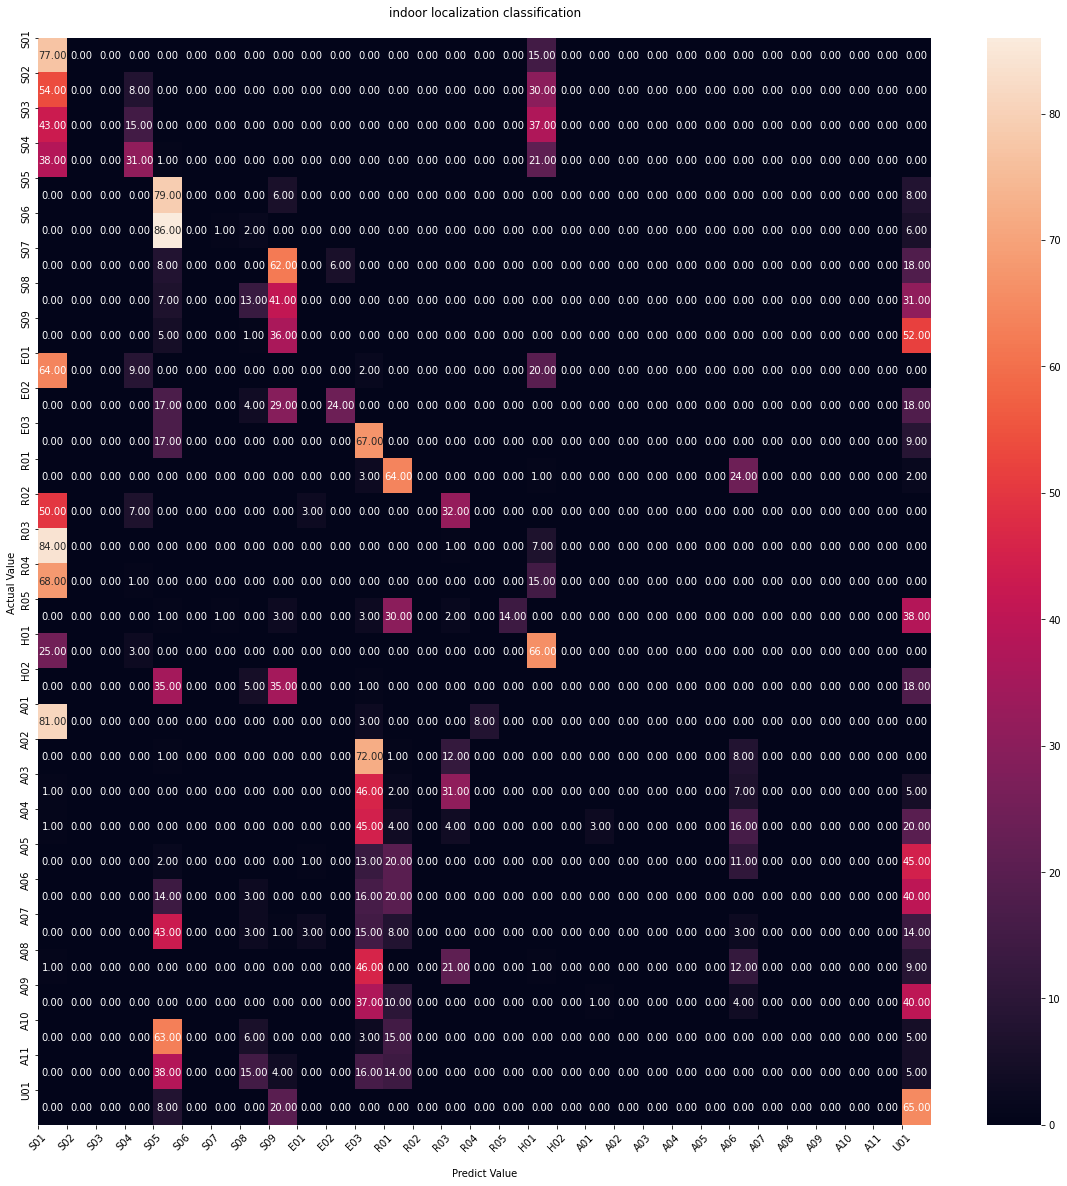

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['S01','S02', 'S03','S04','S05','S06','S07','S08','S09', 'E01','E02','E03', 'R01', 'R02', 'R03', 'R04',
           'R05', 'H01', 'H02', 'A01', 'A02', 'A03','A04','A05','A06','A07','A08','A09','A10', 'A11', 'U01']
y_test_arg=np.argmax(y,axis=1)
y_test2 = le.inverse_transform(y_test_arg)
Y_pred = np.argmax(model_based_tuner.predict(X),axis=1)
Y_pred2 = le.inverse_transform(Y_pred)

# print(Y_pred)
# print('Confusion Matrix')
tick_marks = np.arange(len(labels))
cf_matrix = confusion_matrix(y_test2, Y_pred2, labels = labels)
cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20)) 
ax = sns.heatmap(cf_matrix, annot = True, fmt='.2f')
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

ax.set_title('indoor localization classification\n')
ax.set_xlabel('\nPredict Value')
ax.set_ylabel('Actual Value ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("f1score: ", f1_score(y_true=y_test_arg, y_pred=Y_pred, average='weighted'))
print("accuracy: ", accuracy_score(y_true=y_test_arg, y_pred=Y_pred))
print("precision: ", precision_score(y_true=y_test_arg, y_pred=Y_pred, average='weighted'))
print("recall: ", recall_score(y_true=y_test_arg, y_pred=Y_pred,  average='weighted'))

f1score:  0.10934268283322321
accuracy:  0.187434554973822
precision:  0.12632734761854794
recall:  0.187434554973822


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test_arg

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = model_based_tuner.predict(X)

for i in range(31):
  fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
from numpy.lib.function_base import interp
from itertools import cycle
import random

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(31)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(31):
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 31

fpr['micro'] = all_fpr
tpr['micro'] = mean_tpr
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area = {0:0.2f})'
''.format(roc_auc['micro']),
         color='navy', linestyle=':', linewidth=4)

colors = []
for i in range(31):
  colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
for i, color in zip(range(31), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))


plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test2, Y_pred2, target_names=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(report)

              precision    recall  f1-score   support

         S01       0.00      0.00      0.00        92
         S02       0.00      0.00      0.00        94
         S03       0.00      0.00      0.00        92
         S04       0.00      0.00      0.00        93
         S05       0.00      0.00      0.00        92
         S06       0.00      0.00      0.00        93
         S07       0.00      0.00      0.00        90
         S08       0.00      0.00      0.00        90
         S09       0.00      0.00      0.00        92
         E01       0.00      0.00      0.00        92
         E02       0.00      0.00      0.00        92
         E03       0.00      0.00      0.00        95
         R01       0.97      0.66      0.79        92
         R02       0.22      0.74      0.34        93
         R03       0.74      0.89      0.81        94
         R04       0.00      0.00      0.00        94
         R05       0.43      1.00      0.60        94
         H01       0.00    

In [ ]:
model_based_tuner.save('ios_beacon_DNN_4_no_preprocessing')

INFO:tensorflow:Assets written to: ios_beacon_DNN_4_no_preprocessing/assets


INFO:tensorflow:Assets written to: ios_beacon_DNN_4_no_preprocessing/assets
